In [54]:
# imports
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K

import os
import re
import math
import numpy as np
import pandas as pd
import random
import collections
import json
import shutil
import zipfile
import copy
from datetime import datetime

import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm import tqdm

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# tf version 및 gpu 확인
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())

2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


# cloud shell

$ python

import sentencepiece as spm
import os
corpus_file = os.getenv('HOME')+'/aiffel/bert_pretrain/data/kowiki.txt'
prefix = os.getenv('HOME')+'/aiffel/bert_pretrain/models/ko_32000'
vocab_size = 32000
spm.SentencePieceTrainer.train(f"--input={corpus_file} --model_prefix={prefix} --vocab_size={vocab_size + 7} --model_type=bpe --max_sentence_length=999999 --pad_id=0 --pad_piece=[PAD] --unk_id=1 --unk_piece=[UNK] --bos_id=2 --bos_piece=[BOS] --eos_id=3 --eos_piece=[EOS] --user_defined_symbols=[SEP],[CLS],[MASK]")

In [55]:
data_dir = os.getenv('HOME')+'/aiffel/bert_pretrain/data'
model_dir = os.getenv('HOME')+'/aiffel/bert_pretrain/models'

# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_32000.model")

True

In [56]:
#Q. 특수 token 7개를 제외한 나머지 token들을 출력해봅시다.
vocab_list = []
for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):
            # [[YOUR CODE]]
            token = vocab.id_to_piece(id)  # 핵심 수정 부분
            vocab_list.append(token)

print(vocab_list[:8])

['▁1', '▁이', '으로', '에서', '▁있', '▁2', '▁그', '▁대']


In [57]:
# [CLS], tokens a, [SEP], tokens b, [SEP] 형태의 token 생성
string_a = "추적추적 비가 내리는 날이었어 그날은 왠지 손님이 많아 첫 번에 삼십 전 둘째번 오십 전 오랜만에 받아보는 십 전짜리 백통화 서푼에"
string_b = "손바닥 위엔 기쁨의 눈물이 흘러 컬컬한 목에 모주 한잔을 적셔 몇 달 포 전부터 콜록거리는 아내 생각에 그토록 먹고 싶다던"
tokens_org = ["[CLS]"] + vocab.encode_as_pieces(string_a) + ["[SEP]"] + vocab.encode_as_pieces(string_b) + ["[SEP]"]
print(tokens_org)

['[CLS]', '▁추적', '추', '적', '▁비가', '▁내리는', '▁날', '이었', '어', '▁그날', '은', '▁', '왠', '지', '▁손', '님이', '▁많아', '▁첫', '▁번에', '▁삼', '십', '▁전', '▁둘째', '번', '▁오', '십', '▁전', '▁오랜', '만에', '▁받아', '보는', '▁십', '▁전', '짜리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손바닥', '▁위', '엔', '▁기쁨', '의', '▁눈', '물이', '▁흘러', '▁컬', '컬', '한', '▁목에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전부터', '▁콜', '록', '거리는', '▁아내', '▁생각에', '▁그', '토록', '▁먹고', '▁싶다', '던', '[SEP]']


In [58]:
print(tokens_org)

# 전체 token의 15% mask
mask_cnt = int((len(tokens_org) - 3) * 0.15)
mask_cnt

['[CLS]', '▁추적', '추', '적', '▁비가', '▁내리는', '▁날', '이었', '어', '▁그날', '은', '▁', '왠', '지', '▁손', '님이', '▁많아', '▁첫', '▁번에', '▁삼', '십', '▁전', '▁둘째', '번', '▁오', '십', '▁전', '▁오랜', '만에', '▁받아', '보는', '▁십', '▁전', '짜리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손바닥', '▁위', '엔', '▁기쁨', '의', '▁눈', '물이', '▁흘러', '▁컬', '컬', '한', '▁목에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전부터', '▁콜', '록', '거리는', '▁아내', '▁생각에', '▁그', '토록', '▁먹고', '▁싶다', '던', '[SEP]']


10

In [59]:
# 띄어쓰기 단위로 mask하기 위해서 index 분할
cand_idx = []  # word 단위의 index array
for (i, token) in enumerate(tokens_org):
    if token == "[CLS]" or token == "[SEP]":
        continue
    if 0 < len(cand_idx) and not token.startswith(u"\u2581"):  # u"\u2581"는 단어의 시작을 의미하는 값
        cand_idx[-1].append(i)
    else:
        cand_idx.append([i])

# 결과확인
for cand in cand_idx:
    print(cand, [tokens_org[i] for i in cand])

[1, 2, 3] ['▁추적', '추', '적']
[4] ['▁비가']
[5] ['▁내리는']
[6, 7, 8] ['▁날', '이었', '어']
[9, 10] ['▁그날', '은']
[11, 12, 13] ['▁', '왠', '지']
[14, 15] ['▁손', '님이']
[16] ['▁많아']
[17] ['▁첫']
[18] ['▁번에']
[19, 20] ['▁삼', '십']
[21] ['▁전']
[22, 23] ['▁둘째', '번']
[24, 25] ['▁오', '십']
[26] ['▁전']
[27, 28] ['▁오랜', '만에']
[29, 30] ['▁받아', '보는']
[31] ['▁십']
[32, 33] ['▁전', '짜리']
[34, 35, 36] ['▁백', '통', '화']
[37, 38, 39] ['▁서', '푼', '에']
[41] ['▁손바닥']
[42, 43] ['▁위', '엔']
[44, 45] ['▁기쁨', '의']
[46, 47] ['▁눈', '물이']
[48] ['▁흘러']
[49, 50, 51] ['▁컬', '컬', '한']
[52] ['▁목에']
[53, 54] ['▁모', '주']
[55, 56, 57] ['▁한', '잔', '을']
[58, 59] ['▁적', '셔']
[60] ['▁몇']
[61] ['▁달']
[62] ['▁포']
[63] ['▁전부터']
[64, 65, 66] ['▁콜', '록', '거리는']
[67] ['▁아내']
[68] ['▁생각에']
[69, 70] ['▁그', '토록']
[71] ['▁먹고']
[72, 73] ['▁싶다', '던']


In [60]:
# random mask를 위해서 index 순서를 섞음
random.shuffle(cand_idx)
cand_idx

[[18],
 [44, 45],
 [24, 25],
 [49, 50, 51],
 [31],
 [63],
 [41],
 [52],
 [22, 23],
 [71],
 [17],
 [19, 20],
 [60],
 [32, 33],
 [62],
 [46, 47],
 [29, 30],
 [72, 73],
 [6, 7, 8],
 [64, 65, 66],
 [67],
 [9, 10],
 [26],
 [55, 56, 57],
 [61],
 [34, 35, 36],
 [37, 38, 39],
 [21],
 [58, 59],
 [48],
 [69, 70],
 [4],
 [27, 28],
 [42, 43],
 [14, 15],
 [68],
 [5],
 [11, 12, 13],
 [1, 2, 3],
 [16],
 [53, 54]]

In [61]:
# tokens가 mask되므로 재 실행을 위해서 넣어줌 (테스트용)
tokens = copy.deepcopy(tokens_org)

mask_lms = []  # mask 된 값
for index_set in cand_idx:
    if len(mask_lms) >= mask_cnt:  # 핸재 mask된 개수가 15%를 넘으면 중지
          break
    if len(mask_lms) + len(index_set) > mask_cnt:  # 이번에 mask할 개수를 포함해 15%를 넘으면 skip
          continue
    dice = random.random()  # 0과 1 사이의 확률 값

    for index in index_set:
        masked_token = None
        if dice < 0.8:  # 80% replace with [MASK]
            masked_token = "[MASK]"
        elif dice < 0.9: # 10% keep original
            masked_token = tokens[index]
        else:  # 10% random word
            masked_token = random.choice(vocab_list)
        mask_lms.append({"index": index, "label": tokens[index]})
        tokens[index] = masked_token

print("tokens_org")
print(tokens_org, "\n")
print("tokens")
print(tokens)

tokens_org
['[CLS]', '▁추적', '추', '적', '▁비가', '▁내리는', '▁날', '이었', '어', '▁그날', '은', '▁', '왠', '지', '▁손', '님이', '▁많아', '▁첫', '▁번에', '▁삼', '십', '▁전', '▁둘째', '번', '▁오', '십', '▁전', '▁오랜', '만에', '▁받아', '보는', '▁십', '▁전', '짜리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손바닥', '▁위', '엔', '▁기쁨', '의', '▁눈', '물이', '▁흘러', '▁컬', '컬', '한', '▁목에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전부터', '▁콜', '록', '거리는', '▁아내', '▁생각에', '▁그', '토록', '▁먹고', '▁싶다', '던', '[SEP]'] 

tokens
['[CLS]', '▁추적', '추', '적', '▁비가', '▁내리는', '▁날', '이었', '어', '▁그날', '은', '▁', '왠', '지', '▁손', '님이', '▁많아', '▁첫', '[MASK]', '▁삼', '십', '▁전', '▁둘째', '번', '[MASK]', '[MASK]', '▁전', '▁오랜', '만에', '▁받아', '보는', '▁그레이트', '▁전', '짜리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손바닥', '▁위', '엔', '[MASK]', '[MASK]', '▁눈', '물이', '▁흘러', '[MASK]', '[MASK]', '[MASK]', '▁목에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전부터', '▁콜', '록', '거리는', '▁아내', '▁생각에', '▁그', '토록', '▁먹고', '▁싶다', '던', '[SEP]']


In [62]:
# 순서 정렬 및 mask_idx, mask_label 생성
mask_lms = sorted(mask_lms, key=lambda x: x["index"])
mask_idx = [p["index"] for p in mask_lms]
mask_label = [p["label"] for p in mask_lms]

print("mask_idx   :", mask_idx)
print("mask_label :", mask_label)

mask_idx   : [18, 24, 25, 31, 44, 45, 49, 50, 51, 63]
mask_label : ['▁번에', '▁오', '십', '▁십', '▁기쁨', '의', '▁컬', '컬', '한', '▁전부터']


In [63]:
# Q. 위 코드들을 참고하여 아래 함수를 완성시켜주세요.
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    마스크 생성
    :param tokens: tokens
    :param mask_cnt: mask 개수 (전체 tokens의 15%)
    :param vocab_list: vocab list (random token 용)
    :return tokens: mask된 tokens
    :return mask_idx: mask된 token의 index
    :return mask_label: mask된 token의 원래 값
    """

    # 단어 단위로 mask 하기 위해서 index 분할 (띄어쓰기)
    # 띄어쓰기 단위로 mask하기 위해서 index 분할
    cand_idx = []  # word 단위의 index array
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):  # u"\u2581"는 단어의 시작을 의미하는 값
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])

    # random mask를 위해서 순서를 섞음 (shuffle)
    # random mask를 위해서 index 순서를 섞음
    random.shuffle(cand_idx)

    # mask_lms 정렬 후 mask_idx, mask_label 추출 (sorted 사용)
    # tokens가 mask되므로 재 실행을 위해서 넣어줌 (테스트용)
    tokens = copy.deepcopy(tokens)

    mask_lms = []  # mask 된 값
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:  # 핸재 mask된 개수가 15%를 넘으면 중지
            break
        if len(mask_lms) + len(index_set) > mask_cnt:  # 이번에 mask할 개수를 포함해 15%를 넘으면 skip
            continue
        dice = random.random()  # 0과 1 사이의 확률 값

        for index in index_set:
            masked_token = None
            if dice < 0.8:  # 80% replace with [MASK]
                masked_token = "[MASK]"
            elif dice < 0.9: # 10% keep original
                masked_token = tokens[index]
            else:  # 10% random word
                masked_token = random.choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token

    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]
    mask_label = [p["label"] for p in mask_lms]

    return tokens, mask_idx, mask_label

In [64]:
# tokens가 mask되므로 재 실행을 위해서 넣어줌 (테스트용)
tokens = copy.deepcopy(tokens_org)

tokens, mask_idx, mask_label = create_pretrain_mask(tokens, mask_cnt, vocab_list)

print("tokens_org")
print(tokens_org, "\n")
print("tokens")
print(tokens, "\n")

print("mask_idx   :", mask_idx)
print("mask_label :", mask_label)

tokens_org
['[CLS]', '▁추적', '추', '적', '▁비가', '▁내리는', '▁날', '이었', '어', '▁그날', '은', '▁', '왠', '지', '▁손', '님이', '▁많아', '▁첫', '▁번에', '▁삼', '십', '▁전', '▁둘째', '번', '▁오', '십', '▁전', '▁오랜', '만에', '▁받아', '보는', '▁십', '▁전', '짜리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손바닥', '▁위', '엔', '▁기쁨', '의', '▁눈', '물이', '▁흘러', '▁컬', '컬', '한', '▁목에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전부터', '▁콜', '록', '거리는', '▁아내', '▁생각에', '▁그', '토록', '▁먹고', '▁싶다', '던', '[SEP]'] 

tokens
['[CLS]', '▁추적', '추', '적', '▁비가', '▁내리는', '▁날', '이었', '어', '▁그날', '은', '▁', '왠', '지', '▁손', '님이', '[MASK]', '[MASK]', '▁번에', '▁삼', '십', '▁전', '▁둘째', '번', '▁오', '십', '▁전', '▁오랜', '만에', '▁받아', '보는', '▁십', '▁전', '짜리', '▁백', '통', '화', '[MASK]', '[MASK]', '[MASK]', '[SEP]', '▁손바닥', '▁위', '엔', '▁기쁨', '의', '▁눈', '물이', '[MASK]', '▁컬', '컬', '한', '[MASK]', '끊', '▁규장', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전부터', '▁콜', '록', '거리는', '[MASK]', '▁생각에', '▁그', '토록', '▁먹고', '▁싶다', '던', '[SEP]'] 

mask_idx   : [16, 17, 37, 38,

In [65]:
string = """추적추적 비가 내리는 날이었어
그날은 왠지 손님이 많아
첫 번에 삼십 전 둘째 번 오십 전
오랜만에 받아보는 십 전짜리 백통화 서푼에
손바닥 위엔 기쁨의 눈물이 흘러
컬컬한 목에 모주 한잔을 적셔
몇 달 포 전부터 콜록거리는 아내
생각에 그토록 먹고 싶다던
설렁탕 한 그릇을 이제는 살 수 있어
집으로 돌아가는 길 난 문득 떠올라
아내의 목소리가 거칠어만 가는 희박한 숨소리가
오늘은 왠지 나가지 말라던 내 옆에 있어 달라던
그리도 나가고 싶으면 일찍이라도 들어와 달라던
아내의 간절한 목소리가 들려와
나를 원망하듯 비는 점점 거세져
싸늘히 식어가는 아내가 떠올라 걱정은 더해져
난 몰라 오늘은 운수 좋은 날
난 맨날 이렇게 살 수 있으면 얼마나 좋을까"""

In [66]:
# 줄 단위로 tokenize
doc = [vocab.encode_as_pieces(line) for line in string.split("\n")]
doc[:3]

[['▁추적', '추', '적', '▁비가', '▁내리는', '▁날', '이었', '어'],
 ['▁그날', '은', '▁', '왠', '지', '▁손', '님이', '▁많아'],
 ['▁첫', '▁번에', '▁삼', '십', '▁전', '▁둘째', '▁번', '▁오', '십', '▁전']]

In [67]:
# 최대 길이
n_test_seq = 64
# 최소 길이
min_seq = 8
# [CLS], tokens_a, [SEB], tokens_b, [SEP]
max_seq = n_test_seq - 3

In [68]:
def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    tokens_a, tokens_b의 길이를 줄임 최대 길이: max_seq
    :param tokens_a: tokens A
    :param tokens_b: tokens B
    :param max_seq: 두 tokens 길이의 최대 값
    """

    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a = tokens_a[:-1]
        else:
            tokens_b = tokens_b[:-1]
    return tokens_a, tokens_b



In [69]:
# Q. 위 코드들을 참고하여 아래 함수를 완성시켜주세요.
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    max_seq = n_seq - 3
    instances = []
    current_chunk = []
    current_length = 0
    
    for i in range(len(doc)):
        current_chunk.append(doc[i])
        current_length += len(doc[i])
        
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):
            a_end = 1 if len(current_chunk) == 2 else random.randrange(1, len(current_chunk))
            tokens_a = [token for j in range(a_end) for token in current_chunk[j]]
            tokens_b = [token for j in range(a_end, len(current_chunk)) for token in current_chunk[j]]

            if random.random() < 0.5:
                is_next = 0
                tokens_a, tokens_b = tokens_b, tokens_a
            else:
                is_next = 1
            
            tokens_a, tokens_b = trim_tokens(tokens_a, tokens_b, max_seq)
            if len(tokens_a) == 0 or len(tokens_b) == 0:
                continue  # 유효하지 않은 인스턴스는 건너뜁니다.

            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
        
            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)

            current_chunk = []
            current_length = 0
        
    return instances




In [70]:
instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)

# 최종 데이터셋 결과 확인
for instance in instances:
    print(instance)

{'tokens': ['[CLS]', '선이', '▁번에', '▁삼', '십', '▁전', '▁둘째', '▁번', '▁오', '십', '▁전', '▁오랜', '만에', '▁받아', '보는', '[MASK]', '▁전', '짜리', '▁백', '통', '화', '▁서', '푼', '에', '[MASK]', '▁위', '엔', '▁기쁨', '의', '▁눈', '물이', '▁흘러', '▁컬', '컬', '한', '트리올', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁휘는', '[SEP]', '▁추적', '추', '적', '▁비가', '▁내리는', '▁날', '이었', '어', '▁그날', '은', '[MASK]', '[MASK]', '[MASK]', '▁손', '님이', '▁많아', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'is_next': 0, 'mask_idx': [1, 2, 15, 24, 35, 45, 57, 58, 59], 'mask_label': ['▁첫', '▁번에', '▁십', '▁손바닥', '▁목에', '▁포', '▁', '왠', '지']}
{'tokens': ['[CLS]', '▁아내의', '▁간', '절한', '▁목소리가', '[MASK]', '[MASK]', '[SEP]', '▁생각에', '▁그', '토록', '▁먹고', '▁싶다', '던', '▁설', '렁', '탕', '▁한', '▁그릇', '을', '▁이제는', '▁살', '▁수', '[MASK]', '▁집으로', '▁돌아가는', '▁길', '▁난', '[MASK]', '[MASK]', '▁떠올', '라

In [71]:
corpus_file = os.getenv('HOME')+'/aiffel/bert_pretrain/data/kowiki.txt'

# line count 확인
total = 0
with open(corpus_file, 'r') as in_f:
    for line in in_f:
        total += 1

total

3957761

In [72]:
# 위키가 주제별로 잘 나눠지는지 여부 확인
count = 5

with open(corpus_file, 'r') as in_f:
    doc = []  # 단락 단위로 문서 저장
    for line in tqdm(in_f, total=total):
        line = line.strip()
        if line == "":  # line이 빈줄 일 경우 (새로운 단락)
            if 0 < len(doc):
                if 0 < count:
                    count -= 1
                    print(len(doc), "lines :", doc[0])
                    print(doc[1])
                    print(doc[-1])
                    print()
                else:
                    break
                doc = []
        else:  # 빈 줄이 아니면 doc에 저장
            pieces = vocab.encode_as_pieces(line)
            if 0 < len(pieces):
                doc.append(pieces)
    if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
        print(doc[0])
        print(doc[1])
        print(doc[-1])
        doc = []

  0%|          | 105/3957761 [00:00<11:11, 5895.06it/s]

21 lines : ['▁지미', '▁카터']
['▁제임스', '▁얼', '▁"', '지', '미', '"', '▁카터', '▁주니어', '(,', '▁1924', '년', '▁10', '월', '▁1', '일', '▁~', '▁)', '는', '▁민주당', '▁출신', '▁미국', '▁39', '번째', '▁대통령', '▁(19', '77', '년', '▁~', '▁1981', '년', ')', '이다', '.']
['▁그는', '▁2002', '년', '▁말', '▁인권', '과', '▁중재', '▁역할에', '▁대한', '▁공로를', '▁인정받아', '▁노벨', '▁평화', '상을', '▁받게', '▁되었다', '.']

14 lines : ['▁수학']
['▁수학', '(', '數', '學', ',', '▁)', '은', '▁양', ',', '▁구조', ',', '▁공간', ',', '▁변화', ',', '▁미', '적', '분', '▁등의', '▁개념을', '▁다루는', '▁학문이다', '.', '▁현대', '▁수학', '은', '▁형식', '▁논', '리를', '▁이용해서', '▁공', '리로', '▁구성된', '▁추상', '적', '▁구조를', '▁연구하는', '▁학문', '으로', '▁여겨', '지기도', '▁한다', '.', '▁수학', '은', '▁그', '▁구조와', '▁발전', '▁과정', '에서는', '▁자연', '과학', '에', '▁속하는', '▁물리', '학을', '▁비롯한', '▁다른', '▁학문', '들과', '▁깊은', '▁연', '관을', '▁맺고', '▁있다', '.', '▁하지만', ',', '▁어느', '▁과학의', '▁분야', '들과는', '▁달리', ',', '▁자연', '계에서', '▁관측', '되지', '▁않는', '▁개념', '들에', '▁대해서', '까지', '▁이론을', '▁일반화', '▁및', '▁추상', '화', '시킬', '▁수', '▁있다는', '▁차이가', '▁있다고', '▁한다', '.', '▁수

In [73]:
# instance 생성 기능 확인
count = 5

with open(corpus_file, 'r') as in_f:
    doc = []  # 단락 단위로 문서 저장
    for line in tqdm(in_f, total=total):
        line = line.strip()
        if line == "":  # line이 빈줄 일 경우 (새로운 단락)
            if 0 < len(doc):
                instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)
                # save
                print("doc:", len(doc), "instances:", len(instances))
                print(instances[0])
                print(instances[-1])
                print()
                doc = []
                if 0 < count:  # 테스트를 위해서 부분 처리함
                    count -= 1
                else:
                    break
        else:  # doc에 저장
            if 0 < len(pieces):
                doc.append(pieces)
    if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
        instances = create_pretrain_instances(doc, 128)
        # save
        print("doc:", len(doc), "instances:", len(instances))
        print(instances[0])
        print(instances[-1])
        print()
        doc = []

  0%|          | 105/3957761 [00:00<07:40, 8590.19it/s]

doc: 21 instances: 10
{'tokens': ['[CLS]', '▁유기', '화', '학은', '[MASK]', '[MASK]', '▁이루어진', '老', '奎', '▁연구하는', '▁분', '과', '이다', '.', '▁원래', '▁유기', '▁화합', '물은', '▁식물', '이나', '▁동물', '로부터', '▁추출', '해', '낸', '▁화합', '물을', '▁뜻', '하였으나', '[MASK]', '▁유기', '▁화합', '[SEP]', '▁유기', '화', '학은', '▁탄', '소로', '▁이루어진', '▁화합', '물을', '▁연구하는', '▁분', '과', '이다', '.', '▁원래', '▁유기', '[MASK]', '[MASK]', '▁식물', '이나', '▁동물', '로부터', '▁추출', '해', '낸', '▁화합', '물을', '▁뜻', '하였으나', '▁지금은', '[MASK]', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'is_next': 0, 'mask_idx': [4, 5, 7, 8, 9, 29, 48, 49, 62], 'mask_label': ['▁탄', '소로', '▁화합', '물을', '▁연구하는', '▁지금은', '▁화합', '물은', '▁유기']}
{'tokens': ['[CLS]', '▁유기', '화', '학은', '▁탄', '소로', '▁이루어진', '▁화합', '물을', '▁연구하는', '▁분', '과', '이다', '.', '▁원래', '▁유기', '▁화합', '물은', '[MASK]', '[MASK]', '▁동물', '로부터', '▁추출', '해', '낸'

In [74]:
# Q. 아래 주석에 따라 코드를 완성해주세요.
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """ pretrain 데이터 생성 """
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    # 특수문자 7개를 제외한 vocab_list 생성
    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):
            vocab_list.append(vocab.id_to_piece(id))

    # line count 확인
    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "":  # line이 빈줄 일 경우 (새로운 단락)
                    if doc:
                        save_pretrain_instances(out_f, doc)
                    doc = []
                else:  # line이 빈줄이 아닐 경우 tokenize 해서 doc에 저장
                    tokens = vocab.encode_as_pieces(line)
                    doc.append(tokens)
            if doc:  # 마지막에 처리되지 않은 doc가 있는 경우
                save_pretrain_instances(out_f, doc)


In [75]:
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    max_seq = n_seq - 3
    instances = []
    current_chunk = []
    current_length = 0
    
    for i in range(len(doc)):
        current_chunk.append(doc[i])
        current_length += len(doc[i])
        
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):
            a_end = 1 if len(current_chunk) == 2 else random.randrange(1, len(current_chunk))
            tokens_a = [token for j in range(a_end) for token in current_chunk[j]]
            tokens_b = [token for j in range(a_end, len(current_chunk)) for token in current_chunk[j]]

            if random.random() < 0.5:
                is_next = 0
                tokens_a, tokens_b = tokens_b, tokens_a
            else:
                is_next = 1
            
            tokens_a, tokens_b = trim_tokens(tokens_a, tokens_b, max_seq)
            if len(tokens_a) == 0 or len(tokens_b) == 0:
                continue  # 유효하지 않은 인스턴스는 건너뜁니다.

            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
        
            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)

            current_chunk = []
            current_length = 0
        
    return instances


In [76]:
pretrain_json_path = os.getenv('HOME')+'/aiffel/bert_pretrain/data/bert_pre_train.json'

make_pretrain_data(vocab, corpus_file, pretrain_json_path, 128)

100%|██████████| 3957761/3957761 [06:53<00:00, 9571.99it/s] 


In [77]:
corpus_file = os.getenv('HOME')+'/aiffel/bert_pretrain/data/kowiki.txt'

# line count 확인
total = 0
with open(corpus_file, 'r') as in_f:
    for line in in_f:
        total += 1

total

3957761

In [78]:
# 라인수
total = 0
with open(pretrain_json_path, "r") as f:
    for line in f:
        total += 1
total

862250

In [79]:
n_seq = 128
# [CLS], tokens_a, [SEP], tokens_b, [SEP]
max_seq = n_seq - 3

# 만약 일반적인 Numpy Array에다 데이터를 로딩한다면 이렇게 되겠지만
# enc_tokens = np.zeros((total, n_seq), np.int32)
# dec_tokens = np.zeros((total, n_seq), np.int32)
# labels_nsp = np.zeros((total,), np.int32)
# labels_mlm = np.zeros((total, n_seq), np.int32)

# np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))


enc_tokens[0], enc_tokens[-1], segments[0], segments[-1], labels_nsp[0], labels_nsp[-1], labels_mlm[0], labels_mlm[-1]

(memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0

In [80]:
# 라인 단위로 처리
with open(pretrain_json_path, "r") as f:
    for i, line in enumerate(tqdm(f, total=total)):
        if 5 < i:  # 테스트를 위해서 5개만 확인
            break
        data = json.loads(line)
        # encoder token
        enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
        enc_token += [0] * (n_seq - len(enc_token))
        # segment
        segment = data["segment"]
        segment += [0] * (n_seq - len(segment))
        # nsp label
        label_nsp = data["is_next"]
        # mlm label
        mask_idx = np.array(data["mask_idx"], dtype=np.int)
        mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
        label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
        label_mlm[mask_idx] = mask_label

        print(data)
        print("enc_token:", enc_token)
        print("segment:", segment)
        print("label_nsp:", label_nsp)
        print("label_mlm:", label_mlm)
        print()

        assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

        enc_tokens[i] = enc_token
        segments[i] = segment
        labels_nsp[i] = label_nsp
        labels_mlm[i] = label_mlm

  0%|          | 0/862250 [00:00<?, ?it/s]/tmp/ipykernel_31/767648317.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_idx = np.array(data["mask_idx"], dtype=np.int)
/tmp/ipykernel_31/767648317.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link 

{'tokens': ['[CLS]', '▁지미', '▁카터', '▁제임스', '▁얼', '▁"', '지', '미', '"', '[MASK]', '[MASK]', '[MASK]', '▁1924', '년', '껑', 'ζ', '▁1', '일', '▁~', '▁)', '는', '▁민주당', '▁출신', '[MASK]', '▁39', '번째', '[MASK]', '▁(19', '77', '년', '▁~', '▁1981', '년', ')', '이다', '.', '▁지미', '▁카', '터는', '[MASK]', '[MASK]', '▁섬', '터', '[MASK]', '▁플', '레인', '스', '▁마을에서', '▁태어났다', '.', '[MASK]', '▁공과', '대학교를', '▁졸업하였다', '.', '▁그', '▁후', '▁해군에', '▁들어가', '▁전함', '·', '원자', '력', '·', '[SEP]', '▁1962', '년', '▁조지아', '▁주', '▁상원', '[MASK]', '▁선거에서', '▁낙선', '하나', '▁그', '▁이름은', '▁부정', '선거', '▁', '였', '음을', '▁입증', '하게', '▁되어', '[MASK]', '[MASK]', '[MASK]', '▁1966', '년', '▁조지아', '▁주', '▁지사', '▁선거에', '▁낙선', '하지만', '▁1970', '년', '▁조지아', '▁주', '▁지', '사를', '▁역임했다', '.', 'arg', '▁되기', '▁전', '▁조지아', '주', '▁상원의', '원을', '▁두', '번', '▁연', '임', '했으며', ',', '▁1971', '년부터', '▁1975', '년까지', '[MASK]', '▁지', '사로', '▁근무했다', '.', '▁조지아', '▁주지', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [81]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    학습에 필요한 데이터를 로드
    :param vocab: vocab
    :param filename: 전처리된 json 파일
    :param n_seq: 시퀀스 길이 (number of sequence)
    :param count: 데이터 수 제한 (None이면 전체)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            # 데이터 수 제한
            if count is not None and count <= total:
                break

    # np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            # encoder token
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            # segment
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            # nsp label
            label_nsp = data["is_next"]
            # mlm label
            mask_idx = np.array(data["mask_idx"], dtype=np.int)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
            label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

In [82]:
# 128000건만 메모리에 로딩
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128, count=128000)

  0%|          | 0/128000 [00:00<?, ?it/s]/tmp/ipykernel_31/3092669743.py:42: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_idx = np.array(data["mask_idx"], dtype=np.int)
/tmp/ipykernel_31/3092669743.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note lin

data load early stop 128000 128000


In [83]:
# 처음과 마지막 확인
pre_train_inputs[0][0], pre_train_inputs[0][-1], pre_train_inputs[1][0], pre_train_inputs[1][-1], pre_train_labels[0][0], pre_train_labels[0][-1], pre_train_labels[1][0], pre_train_labels[1][-1]

(memmap([    5, 16415, 25250,  3324,  1042,   103, 27610, 27686, 27718,
             6,     6,     6,  5708, 27625, 29622, 31759,     7, 27629,
           203,   241, 27602,  4867,   788,     6,  5898,   796,     6,
          1647,  4630, 27625,   203,  3008, 27625, 27616,    16, 27599,
         16415,   207,  4612,     6,     6,   630, 27714,     6,   429,
          5346, 27626, 14406,  1605, 27599,     6, 14146, 15991,  8637,
         27599,    13,    81, 25987,  2247, 15033, 27873, 14475, 27813,
         27873,     4,  3715, 27625,  5551,    37, 11234,     6,  5249,
          9858,  3294,    13,  1636,  2386,  2163, 27596, 27671,   969,
          8047,   173,   607,     6,     6,     6,  3926, 27625,  5551,
            37, 18995,  8198,  9858,  1447,  1921, 27625,  5551,    37,
            18,   451,  4267, 27599, 25536,  6436,    25,  5551, 27646,
         18205,   928,   157, 27821,    61, 27773,   530, 27604,  3372,
           523,  3409,   673,     6,    18,   982, 13264, 27599,

In [84]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask
print("슝=3")

슝=3


In [85]:
@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))

print("슝=3")

슝=3


In [86]:
def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer
print("슝=3")

슝=3


In [87]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)
print("슝=3")

슝=3


In [88]:
class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model

    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")

    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs
print("슝=3")

슝=3


In [89]:
class PositionEmbedding(tf.keras.layers.Layer):
    """
    Position Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: position embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed
print("슝=3")

슝=3


In [90]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out
print("슝=3")

슝=3


In [91]:
# Q. 주석과 코드를 참조하여 아래 클래스를 완성해주세요.
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out
print("슝=3")

슝=3


In [92]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val
print("슝=3")

슝=3


In [93]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out
print("슝=3")

슝=3


In [94]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: (enc_tokens, segments)
        :return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        """
        enc_tokens, segments = inputs

        enc_self_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = self.embedding(enc_out, mode="linear")
        return logits_cls, logits_lm

    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed
print("슝=3")

슝=3


In [95]:
# Encoder Layer class 정의
class PooledOutput(tf.keras.layers.Layer):
    def __init__(self, config, n_output, name="pooled_output"):
        super().__init__(name=name)

        self.dense1 = tf.keras.layers.Dense(config.d_model, activation=tf.nn.tanh, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.dense2 = tf.keras.layers.Dense(n_output, use_bias=False, activation=tf.nn.softmax, name="nsp", kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        return outputs
print("슝=3")

슝=3


In [96]:
def build_model_pre_train(config):
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    segments = tf.keras.layers.Input((None,), name="segments")

    bert = BERT(config)
    logits_cls, logits_lm = bert((enc_tokens, segments))

    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    outputs_nsp = tf.keras.layers.Softmax(name="nsp")(logits_cls)

    outputs_mlm = tf.keras.layers.Softmax(name="mlm")(logits_lm)

    model = tf.keras.Model(inputs=(enc_tokens, segments), outputs=(outputs_nsp, outputs_mlm))
    return model
print("슝=3")

슝=3


In [97]:
config = Config({"d_model": 256, "n_head": 4, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 3, "n_seq": 256, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 256,
 'n_head': 4,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 3,
 'n_seq': 256,
 'n_vocab': 32007,
 'i_pad': 0}

In [98]:
n_seq = 10

# make test inputs
enc_tokens = np.random.randint(0, len(vocab), (10, n_seq))
segments = np.random.randint(0, 2, (10, n_seq))
labels_nsp = np.random.randint(0, 2, (10,))
labels_mlm = np.random.randint(0, len(vocab), (10, n_seq))

test_model = build_model_pre_train(config)
test_model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=["acc"])

# test model fit
test_model.fit((enc_tokens, segments), (labels_nsp, labels_mlm), epochs=2, batch_size=5)

Epoch 1/2
2/2 [==============================] - 3s 15ms/step - loss: 11.2227 - nsp_loss: 0.7743 - mlm_loss: 10.4484 - nsp_acc: 0.5000 - mlm_acc: 0.0000e+00
Epoch 2/2
2/2 [==============================] - 0s 14ms/step - loss: 10.0172 - nsp_loss: 0.6251 - mlm_loss: 9.3921 - nsp_acc: 0.8000 - mlm_acc: 0.0200


In [99]:
def lm_loss(y_true, y_pred):
    """
    loss 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return loss * 20  # mlm을 더 잘 학습하도록 20배 증가 시킴
print("슝=3")

슝=3


In [100]:
def lm_acc(y_true, y_pred):
    """
    acc 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 정답 여부 확인
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask
    # 정확도 계산
    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    return accuracy
print("슝=3")

슝=3


In [101]:
class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    CosineSchedule Class
    """
    def __init__(self, train_steps=4000, warmup_steps=2000, max_lr=2.5e-4):
        """
        생성자
        :param train_steps: 학습 step 총 합
        :param warmup_steps: warmup steps
        :param max_lr: 최대 learning rate
        """
        super().__init__()

        assert 0 < warmup_steps < train_steps
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num):
        """
        learning rate 계산
        :param step_num: 현재 step number
        :retrun: 계산된 learning rate
        """
        state = tf.cast(step_num <= self.warmup_steps, tf.float32)
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / max(1, self.train_steps - self.warmup_steps)
        lr2 = 0.5 * (1.0 + tf.math.cos(math.pi * progress))
        return (state * lr1 + (1 - state) * lr2) * self.max_lr
print("슝=3")

슝=3


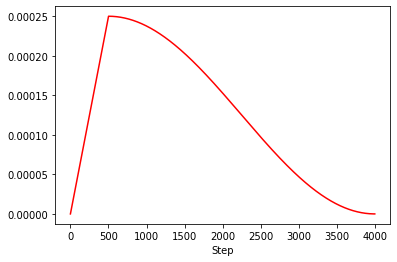

In [102]:
# compute lr
test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500)
lrs = []
for step_num in range(4000):
    lrs.append(test_schedule(float(step_num)).numpy())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.show()

In [103]:
# 모델 생성
pre_train_model = build_model_pre_train(config)
pre_train_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_tokens (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
segments (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
bert (BERT)                     ((None, 256), (None, 10629632    enc_tokens[0][0]                 
                                                                 segments[0][0]                   
__________________________________________________________________________________________________
pooled_nsp (PooledOutput)       (None, 2)            66304       bert[0][0]                 

In [104]:
epochs = 10
batch_size = 64

# optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# compile
pre_train_model.compile(loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss), optimizer=optimizer, metrics={"nsp": "acc", "mlm": lm_acc})

train_steps: 20000


In [105]:
save_weights = tf.keras.callbacks.ModelCheckpoint(f"{model_dir}/bert_pre_train.hdf5", monitor="mlm_lm_acc", verbose=1, save_best_only=True, mode="max", save_freq="epoch", save_weights_only=True)

In [106]:
# train
history = pre_train_model.fit(
    pre_train_inputs,
    pre_train_labels,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[save_weights],
    validation_split=0.1  # 검증 데이터 비율, 필요에 따라 조정하세요
)


Epoch 1/10
1800/1800 [==============================] - 521s 288ms/step - loss: 22.8563 - nsp_loss: 0.6502 - mlm_loss: 22.2060 - nsp_acc: 0.5909 - mlm_lm_acc: 0.0835 - val_loss: 21.6461 - val_nsp_loss: 0.6332 - val_mlm_loss: 21.0129 - val_nsp_acc: 0.6084 - val_mlm_lm_acc: 0.1041

Epoch 00001: mlm_lm_acc improved from -inf to 0.08353, saving model to /aiffel/aiffel/bert_pretrain/models/bert_pre_train.hdf5
Epoch 2/10
1800/1800 [==============================] - 520s 289ms/step - loss: 20.5047 - nsp_loss: 0.6187 - mlm_loss: 19.8860 - nsp_acc: 0.6341 - mlm_lm_acc: 0.1179 - val_loss: 20.3936 - val_nsp_loss: 0.6029 - val_mlm_loss: 19.7908 - val_nsp_acc: 0.6525 - val_mlm_lm_acc: 0.1212

Epoch 00002: mlm_lm_acc improved from 0.08353 to 0.11794, saving model to /aiffel/aiffel/bert_pretrain/models/bert_pre_train.hdf5
Epoch 3/10
1800/1800 [==============================] - 520s 289ms/step - loss: 19.2958 - nsp_loss: 0.5900 - mlm_loss: 18.7058 - nsp_acc: 0.6860 - mlm_lm_acc: 0.1344 - val_loss: 19.

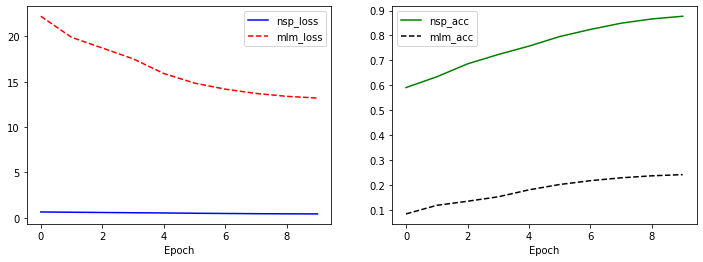

In [107]:
# training result
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['nsp_loss'], 'b-', label='nsp_loss')
plt.plot(history.history['mlm_loss'], 'r--', label='mlm_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['nsp_acc'], 'g-', label='nsp_acc')
plt.plot(history.history['mlm_lm_acc'], 'k--', label='mlm_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

# 회고

- **10번째 에폭 결과**

```
Epoch 10/10
1800/1800 [==============================] - 521s 290ms/step - loss: 13.6260 - nsp_loss: 0.4334 - mlm_loss: 13.1925 - nsp_acc: 0.8772 - mlm_lm_acc: 0.2413 - val_loss: 15.8007 - val_nsp_loss: 0.6632 - val_mlm_loss: 15.1375 - val_nsp_acc: 0.6405 - val_mlm_lm_acc: 0.2129
```

1. 손실(Loss) 지표:

    - 전체 손실(loss): 13.6260

    - NSP(Next Sentence Prediction) 손실: 0.4334

    - MLM(Masked Language Model) 손실: 13.1925

훈련 세트에서의 전체 손실은 NSP와 MLM 손실의 합으로 계산됩니다.

2. 정확도(Accuracy) 지표:

    - NSP 정확도: 0.8772 (87.72%)

    - MLM 정확도: 0.2413 (24.13%)

NSP 정확도가 높은 것은 모델이 문장 간의 관계를 잘 예측하고 있음을 의미합니다.

3. 검증(Validation) 지표:

    - 검증 손실: 15.8007

    - 검증 NSP 손실: 0.6632

    - 검증 MLM 손실: 15.1375

    - 검증 NSP 정확도: 0.6405 (64.05%)

    - 검증 MLM 정확도: 0.2129 (21.29%)

### loss는 전반적으로 줄고 accuracy는 상승하는 결과를 보입니다! 나름 학습이 잘 된 것 같습니다!